## EXAMPLE: Application of Matched Filter for Gravitational microlensing

* here we are going to generate some microlensing waves using the Microlensing generator created by T. Anguita & F. Förster [https://github.com/tanguita/microlensing ]. And we will test the behavior of Matched Filter for Irregular sampled data and using signal Decomposition for calculation of inverse Fourier Transform.

In [1]:
# import libraries
import numpy as np
import scipy.signal as signal
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# microlens parameter and event generators
import sys
sys.path.append("./microlensing/lib")
sys.path.append("..")
from microlensing import *
from mfilter.implementations.simulate import SimulateSignal
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *

ImportError: No module named 'microlensing'

In [2]:
# generate parameter generator object and sample parameters
parfile = "test.txt" # here put your favourite file with columns tE, U0 and fs, in data directory
pargen = microlens_pars(parsfile = "./microlensing/data/%s" % parfile)
nsample = 100
pars = pargen.sample(nsample)

10

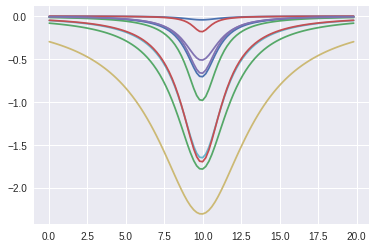

In [3]:
# define times and plot
dt = 0.2
n = 100
struct = "slight"
times = TimesSamples(n=n, delta=dt, struct=struct)
n_templates = 10

def gen_templates(n_templates, times, t0_default=None, basis=None, window=1):
    if basis is None:
        basis = random.sample(range(0, len(pars['tE'])), n_templates)
        
    basis = np.array(basis)
    templates = []
    fig, ax = plt.subplots()
    j = 0
    l = len(basis)
    while j < l:
        i = basis[j]
        if pars['tE'][i] == 0.0:
            basis = np.delete(basis, j)
            l = len(basis)
            pass
        else:
            t0 = np.random.random() * times.duration if t0_default is None else t0_default
            ml = microlens(tE = pars['tE'][i], U0 = pars['U0'][i], fs = pars['fs'][i], t0 = t0)
            templates.append(TimeSeries(ml.eval(times), times=times))
            ax.plot(times, window * ml.eval(times))
            j += 1
#     ax.set_ylim(ax.get_ylim()[::-1])
    return templates, basis
        
templates, basis = gen_templates(n_templates, times, t0_default=times.duration/2 + times.min(), basis=None)
len(templates)

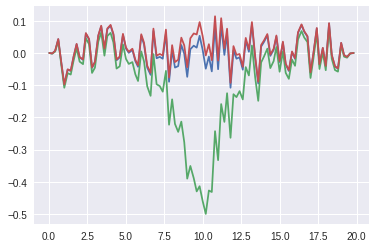

In [4]:
def gen_data(templates, times, numbers=[0, 3], noise_level=0.05):
    # take two template as the input data and add some noise
    window = signal.tukey(len(times), alpha=1./8)
    noise = np.random.normal(0, noise_level, len(times))
    data1 = TimeSeries(window*(templates[numbers[0]] + noise), times=times)
    data2 = TimeSeries(window*(templates[numbers[1]] + noise), times=times)
    # a third input data will be only noise
    data3 = TimeSeries(noise*window, times=times)
    return [data1, data2, data3]

datas = gen_data(templates, times)
fig, ax = plt.subplots()
ax.plot(times, datas[0])
ax.plot(times, datas[1])
ax.plot(times, datas[2])
# ax.set_ylim(ax.get_ylim()[::-1])

(100, 793)


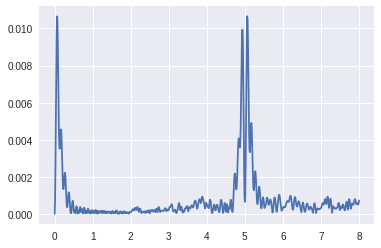

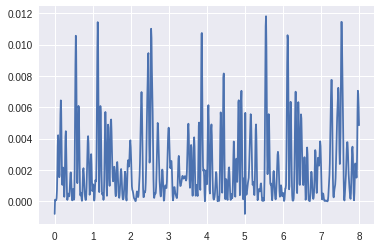

In [5]:
# then check several match between data and all templates generated. In order to save some computational
# time, we will define the frequencies and the frequency domain data/templates before
# first define the sampling grid
samples_per_peak = 5


freqs = FrequencySamples(input_time=times,
                        minimum_frequency=0,
                        maximum_frequency=8,
                        samples_per_peak=samples_per_peak)

F = Dictionary(times, freqs)
reg = RidgeRegression(alpha=0.001, phi=F)
# reg = ElasticNetRegression(alpha=0.01, l1_ratio=0.7, phi=F)
# reg = LassoRegression(alpha=0.001, phi=F)
print(F.shape(splited=False))

def data_transform(datas, reg):
    
    stilde1 = datas[0].to_frequencyseries(reg=reg)
    stilde2 = datas[1].to_frequencyseries(reg=reg)
    stilde3 = datas[2].to_frequencyseries(reg=reg)
    return [stilde1, stilde2, stilde3]

def data_psd(datas, freqs):
    psd1 = datas[0].psd(freqs)
    psd2 = datas[1].psd(freqs)
    psd3 = datas[2].psd(freqs)
    return [psd1, psd2, psd3]

def templates_transform(templates, reg):
    htildes = []
    for temp in templates:
        htildes.append(temp.to_frequencyseries(reg=reg))
    return htildes

stildes = data_transform(datas, reg)
psds = data_psd(datas, freqs)
htildes = templates_transform(templates, reg)

plt.plot(freqs, abs(htildes[3]), alpha=1)
# plt.plot(freqs, abs(stilde2), 'r', alpha=0.5)

plt.figure()
plt.plot(freqs, psds[0])

In [6]:
def all_match(stilde, htildes, psd, reg, times):
    matchs = []
    idx_of_shift = []
    for htilde in htildes:
        snr, idx = match(htilde, stilde, reg=reg, psd=psd, times=times, v2_norm=None, v1_norm=None)
        matchs.append(round(snr, 3))
        idx_of_shift.append(idx)
    
    print("best match of ", max(matchs), "occurs for template number: ", np.array(matchs).argmax())
    return matchs, idx_of_shift

for data0, created with template number 3 we get:
best match of  0.858 occurs for template number:  2

for data1, created with template number 0 we get:
best match of  0.365 occurs for template number:  8

for data2, created only with noise we get:
best match of  0.144 occurs for template number:  25


[0.848, 0.836, 0.858, 0.856, 0.854, 0.745, 0.817, 0.854, 0.844, 0.856, 0.839, 0.85, 0.84, 0.855, 0.812, 0.858, 0.858, 0.812, 0.856, 0.853, 0.83, 0.842, 0.857, 0.849, 0.839, 0.809]
[0.335, 0.324, 0.351, 0.346, 0.342, 0.29, 0.311, 0.342, 0.365, 0.359, 0.326, 0.337, 0.328, 0.36, 0.308, 0.354, 0.354, 0.308, 0.36, 0.342, 0.32, 0.328, 0.358, 0.364, 0.327, 0.362]
[0.133, 0.131, 0.135, 0.135, 0.134, 0.128, 0.128, 0.134, 0.139, 0.137, 0.132, 0.133, 0.132, 0.137, 0.128, 0.135, 0.136, 0.128, 0.137, 0.134, 0.13, 0.132, 0.136, 0.138, 0.132, 0.144]


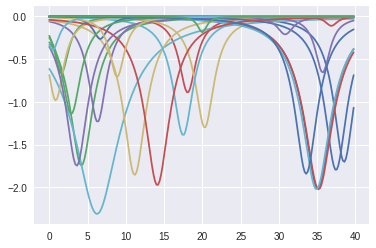

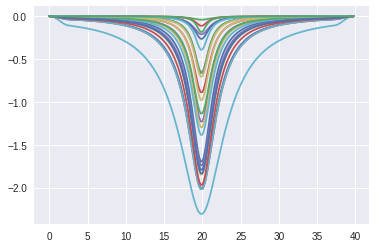

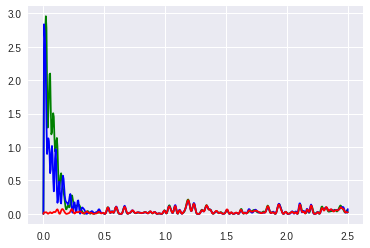

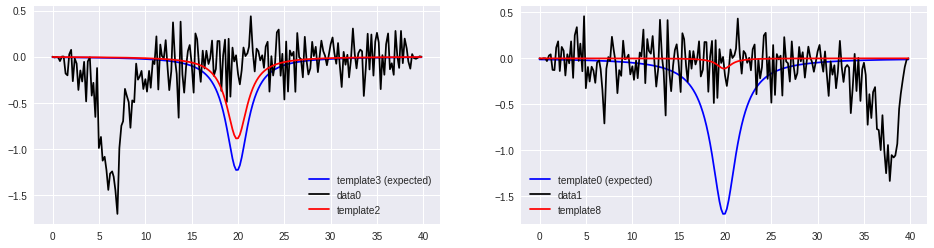

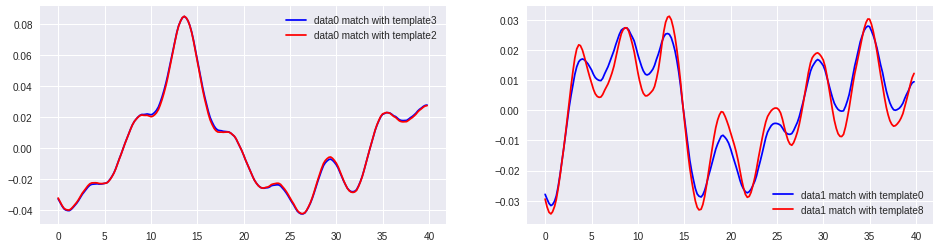

In [7]:

def run(basis=None):
    # define times and plot
    dt = 0.2
    n = 200
    struct = "slight"
    times = TimesSamples(n=n, delta=dt, struct=struct)
    n_templates = 30
    templates, basis = gen_templates(n_templates, times, basis=basis)
    numbers = np.random.randint(0, len(templates), 2)
    datas = gen_data(templates, times, numbers=numbers, noise_level=0.2)
    # regenerate all templates using same t0, in pratice we will generate al templates 
    # at same time for simplicity
    window = signal.tukey(len(times), alpha=1./8)
    templates, basis = gen_templates(n_templates, times, 
                                     t0_default=times.duration/2 + times.min(), basis=basis, window=window)
    
    samples_per_peak = 5
    freqs = FrequencySamples(input_time=times,
                        minimum_frequency=0,
                        maximum_frequency=2.5,
                        samples_per_peak=samples_per_peak)

    F = Dictionary(times, freqs)
    reg = RidgeRegression(alpha=100, phi=F)
    stildes = data_transform(datas, reg)
    psds = data_psd(datas, freqs)
    plt.figure()
    plt.plot(freqs, psds[0], 'g')
    plt.plot(freqs, psds[1], 'b')
    plt.plot(freqs, psds[2], 'r')
    htildes = templates_transform(templates, reg)
    print("for data0, created with template number", numbers[0], "we get:")
    matchs1, idxs1 = all_match(stildes[0], htildes, psds[2], reg, times)
    print("\nfor data1, created with template number", numbers[1], "we get:")
    matchs2, idxs2 = all_match(stildes[1], htildes, psds[2], reg, times)
    print("\nfor data2, created only with noise we get:")
    matchs3, idxs3 = all_match(stildes[2], htildes, psds[2], reg, times)
    print("\n")
    print(matchs1)
    print(matchs2)
    print(matchs3)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    n_t = numbers[0]
    ax[0].plot(times, templates[n_t], 'b', label="template"+str(n_t) + " (expected)")
    ax[0].plot(times, datas[0], 'k', label="data0")
    n_t = np.array(matchs1).argmax()
    if n_t != numbers[0]:
        ax[0].plot(times, templates[n_t], 'r', label="template" + str(n_t))
    ax[0].legend()
    
    n_t = numbers[1]
    ax[1].plot(times, templates[n_t], 'b', label="template" + str(n_t) + " (expected)")
    ax[1].plot(times, datas[1], 'k', label="data1")
    n_t = np.array(matchs2).argmax()
    if n_t != numbers[1]:
        ax[1].plot(times, templates[n_t], 'r', label="template" + str(n_t))
    ax[1].legend()
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    snr01 = matched_filter(htildes[numbers[0]], stildes[0], psd=psds[2], reg=reg, 
                         times=times, unitary_energy=True)
    snr02 = matched_filter(htildes[np.array(matchs1).argmax()], stildes[0], psd=psds[2], reg=reg, 
                         times=times, unitary_energy=True)
    ax[0].plot(times, snr01, 'b', label="data0 match with template" + str(numbers[0]))
    ax[0].plot(times, snr02, 'r', label="data0 match with template" + str(np.array(matchs1).argmax()))
    ax[0].legend()
    
    snr11 = matched_filter(htildes[numbers[1]], stildes[1], psd=psds[2], reg=reg, 
                         times=times, unitary_energy=True)
    snr12 = matched_filter(htildes[np.array(matchs2).argmax()], stildes[1], psd=psds[2], reg=reg, 
                         times=times, unitary_energy=True)
    ax[1].plot(times, snr11, 'b', label="data1 match with template" + str(numbers[1]))
    ax[1].plot(times, snr12, 'r', label="data1 match with template" + str(np.array(matchs2).argmax()))
    ax[1].legend()
    return basis
    
basis = run(basis=None)
# _ = run(basis=basis)